# DFE inference
## Estimating the deleterious DFE
A short overview of basic DFE inference and bootstrapping is available in the {doc}`quickstart guide <../R/quickstart>`. DFE inference requires one `neutral` and one `selected` SFS. In this example we use the bundled `Betula pendula` (silver birch) data. By default, bootstrapping is performed automatically, and the inference estimates only the deleterious component of the DFE using {class}`~fastdfe.parametrization.GammaExpParametrization`.

In [ ]:
library(fastdfe)

# load the fastdfe package
fd <- load_fastdfe()

In [1]:
setwd("/Users/au732936/PycharmProjects/fastDFE")

reticulate::use_condaenv("/Users/au732936/miniconda3/envs/dev-r-fastdfe", required = TRUE)
reticulate::py_run_string("import numpy as np; np.set_printoptions(legacy='1.25')")

source("R/fastdfe.R")
fd <- load_fastdfe()

fd$Settings$parallelize <- FALSE

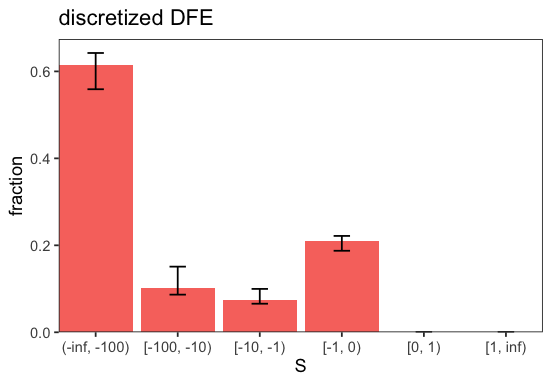

In [2]:
sfs_neut <- fd$Spectrum(c(177130, 997, 441, 228, 156, 117, 114, 83, 105, 109, 0))
sfs_sel <- fd$Spectrum(c(797939, 1329, 499, 265, 162, 104, 117, 90, 94, 119, 0))

# create inference object
inf <- fd$BaseInference(
    sfs_neut = sfs_neut,
    sfs_sel = sfs_sel
)

# run inference
sfs_modelled <- inf$run()

p <- inf$plot_discretized();

It is always good practice to check the variability of estimates across optimization runs to ensure stability. Here, both the standard deviations across initial runs and across runs within each bootstrap sample are low, indicating stable estimates. Individual runs and bootstrap results can be inspected in the corresponding dataframes (cf. {attr}`~fastdfe.base_inference.BaseInference.runs` and {attr}`~fastdfe.base_inference.BaseInference.bootstraps`).

In [3]:
inf$runs[sapply(inf$runs, is.numeric)]

all.S_d,all.b,all.p_b,all.S_b,all.eps,all.h,likelihood
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-33894.99,0.1305440,0,1,0,0.5,-35.43797
-33893.68,0.1305446,0,1,0,0.5,-35.43797
-33888.72,0.1305467,0,1,0,0.5,-35.43797
-33894.10,0.1305444,0,1,0,0.5,-35.43797
-33893.74,0.1305445,0,1,0,0.5,-35.43797
-33898.59,0.1305425,0,1,0,0.5,-35.43797
-33894.18,0.1305443,0,1,0,0.5,-35.43797
-33890.69,0.1305458,0,1,0,0.5,-35.43797
-33891.09,0.1305456,0,1,0,0.5,-35.43797


In [4]:
head(inf$bootstraps[sapply(inf$bootstraps, is.numeric)], 10)

,S_d,b,p_b,S_b,eps,h,likelihood,i_best_run,likelihoods_std,alpha
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-100000.000,0.1152711,0,1,0,0.5,-48.66672,0,3.088417e-09,0
2,-23100.329,0.1327666,0,1,0,0.5,-39.45439,0,4.049241e-10,0
3,-30897.031,0.1265250,0,1,0,0.5,-44.11652,1,2.611387e-10,0
4,-100000.000,0.1170411,0,1,0,0.5,-40.33266,0,2.842171e-14,0
5,-27266.630,0.1347701,0,1,0,0.5,-38.64248,1,1.068940e-09,0
6,-100000.000,0.1150590,0,1,0,0.5,-36.25929,1,2.541285e-01,0
7,-16452.728,0.1420235,0,1,0,0.5,-40.44355,1,3.198863e-10,0
8,-5995.290,0.1644735,0,1,0,0.5,-43.46204,0,8.127756e-10,0
9,-2350.228,0.1879434,0,1,0,0.5,-38.71198,0,8.384404e-12,0


We can also plot the parameter distributions across bootstrap samples to visualize uncertainty. We see that the mean strength of deleterious selection `S_d` often reaches the lower bounds of `-1e5`. Perhaps a different DFE parameterization or a more complex DFE model would be more appropriate here. It should also be noted that the spectra used in this example are far from exemplary, as they contain few SNPs and have a small sample size.

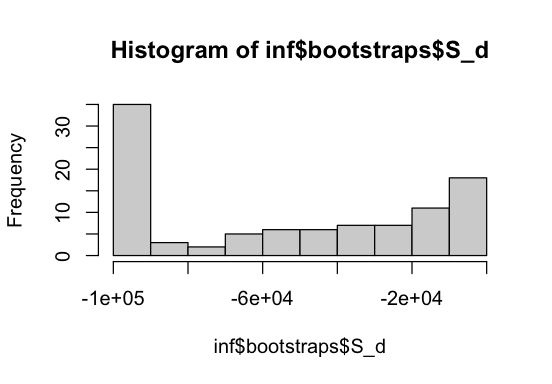

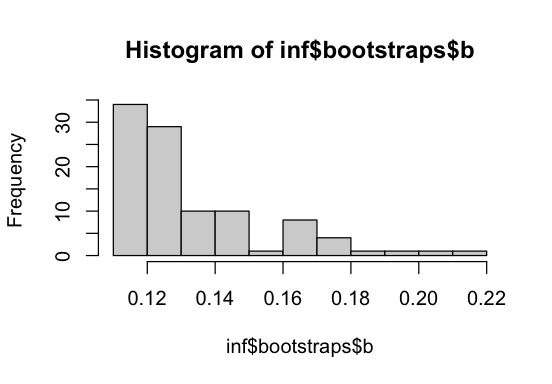

In [5]:
hist(inf$bootstraps$S_d); hist(inf$bootstraps$b)

We can also inspect how parameters covary.

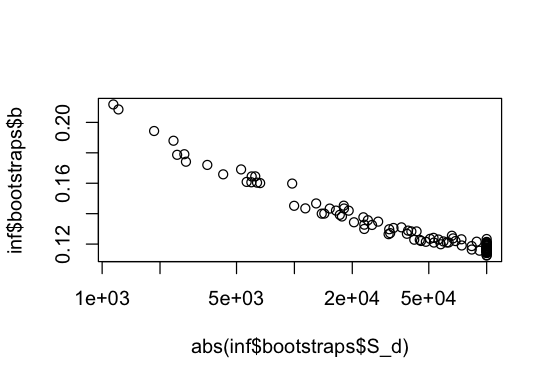

In [6]:
plot(abs(inf$bootstraps$S_d), inf$bootstraps$b, log="x")

We observe a slight dependence between the mean `S_d` and the shape parameter `b` of {class}`~fastdfe.parametrization.GammaExpParametrization`. This is because a large fraction of moderately deleterious mutations and a smaller fraction of strongly deleterious mutations can leave a similar signal in the SFS. Spectra with larger sample sizes might facilitate disentangling the two.

## Estimating beneficial effects
Parameters can be held fixed during maximum-likelihood optimization, and this was already done internally in the example above. By default, fastDFE infers only the deleterious DFE, fixes the ancestral-allele misidentification rate `eps`, and assumes semi-dominant mutations (`h = 0.5`) (see {attr}`~fastdfe.base_inference.BaseInference.fixed_params`). Here, we estimate the full DFE, allowing for beneficial mutations by letting the parameters `S_b` and `p_b` of {class}`~fastdfe.parametrization.GammaExpParametrization` vary, while `eps` and `h` remain fixed. The fixed parameters are wrapped in a dictionary under the key `all`, meaning these settings apply to all SFS types, which matters when running joint inference (cf. {class}`~fastdfe.joint_inference.JointInference`).

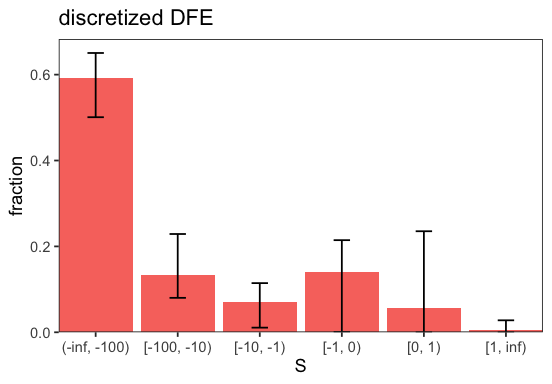

In [7]:
# create inference object
inf <- fd$BaseInference(
    sfs_neut = sfs_neut,
    sfs_sel = sfs_sel,
    fixed_params = list(all = list(eps = 0, h = 0.5))
)

# run inference
sfs_modelled <- inf$run()

p <- inf$plot_discretized();

The inferred full DFE shows substantial uncertainty, which is expected with a small sample and few SNPs. This is most pronounced for the [-1, 0] and [0, 1] bins, where many mutations are effectively neutral and provide little signal. Adjusting the discretization intervals can help reveal the structure more clearly (cf. {func}`~fastdfe.base_inference.BaseInference.plot_discretized`).

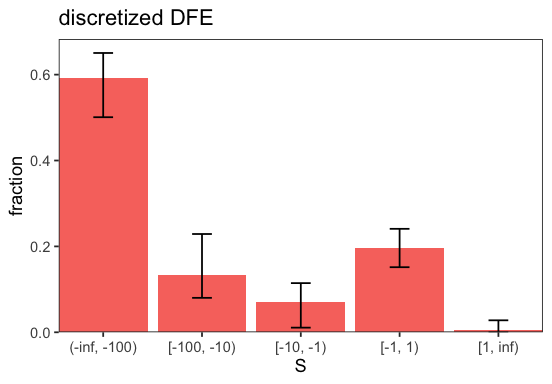

In [8]:
p <- inf$plot_discretized(intervals = c(-Inf, -100, -10, -1, 1, Inf));

## Ancestral-allele misidentification
We can also adjust for ancestral-allele misidentification by letting parameter `eps` vary. `eps` is the probability that an allele is misidentified as derived when it is actually ancestral, and vice versa (cf. {func}`~fastdfe.spectrum.Spectrum.misidentify`). This can correct biases to the SFS caused by mis-polarization, but `eps` is somewhat difficult to interpret because it is applied simultaneously to both the neutral and selected SFS. In addition, `eps` assumes the fraction of ancestral misidentification to be constant across site classes, but in practise errors may differ across classes. Nevertheless, below, we infer the full DFE while allowing `eps` to vary.

In [9]:
inf <- fd$BaseInference(
    sfs_neut = sfs_neut,
    sfs_sel = sfs_sel,
    fixed_params = list(all = list(h=0.5))
)

sfs_modelled <- inf$run()

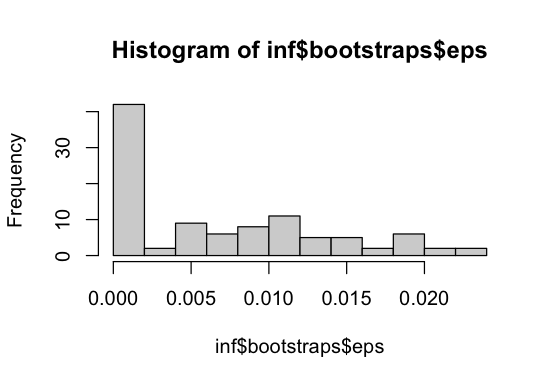

In [10]:
hist(inf$bootstraps$eps)

`eps` is estimated to be rather low, indicating that ancestral-allele misidentification is not a major issue in this dataset, or, at least, that including it that does not significantly improve the model fit. We can also check this in a more principled way by performing a likelihood-ratio test as done below.

## Nested model comparison
We can automatically check for the significance of include ancestral-allele misidentification and beneficial fitness affects using likelihood ratio tests. This is done with {func}`~fastdfe.base_inference.BaseInference.plot_nested_models`. The LRTs are performed by comparing the likelihood of the inferred DFE to the likelihood of a nested model where some parameters are held fixed. Alternatively, we can use {func}`~fastdfe.base_inference.BaseInference.compare_nested` to directly compare two nested models.

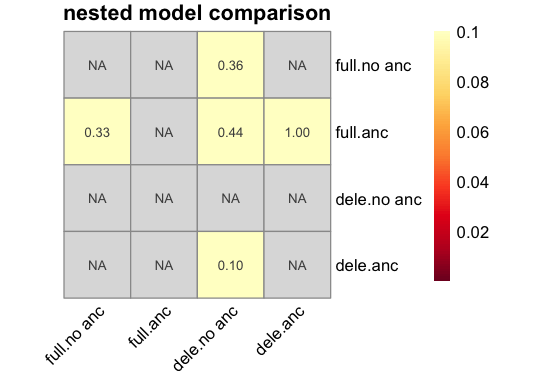

In [11]:
p <- inf$plot_nested_models();

Including ancestral allele misidentification or beneficial mutations does not appear to improve the fit significantly.

## Dominance effects
By default, fastDFE assumes semi-dominance (`h = 0.5`), which is more or less appropriate depending on the organism and type of mutations considered. We can change the dominance coefficient to a different value of `h` if we believe this is more appropriate. However, in practise, `h` often depends on the strength of selection, with more deleterious mutations being more recessive. To model this, we can specify a callback function that returns the dominance coefficient as a function of the selection coefficient `S = 4Ne`.

In the example below, we use an exponential decay: `h` is about 0.4 for neutral mutations and approaches 0 for strongly deleterious ones. The callback also receives `h` itself, allowing the dominance function to be parametrized and optimized; for simplicity, this parameter is still called `h`. Its bounds can be set via {attr}`~fastdfe.base_inference.BaseInference.bounds`.

In [12]:
inf <- fd$BaseInference(
    sfs_neut = sfs_neut,
    sfs_sel = sfs_sel,
    fixed_params = list(all = list(eps = 0, h = 0, p_b = 0, S_b = 1)),
    h_callback=function(h, S) { 0.4 * exp(-0.1 * abs(S)) }
)

sfs_modelled <- inf$run()

Let's compare the inferred DFE under this dominance relationship to that of the default semi-dominant model.

In [13]:
inf2 <- fd$BaseInference(
    sfs_neut = sfs_neut,
    sfs_sel = sfs_sel,
    fixed_params = list(all = list(eps = 0, h = 0.5, p_b = 0, S_b = 1))
)

sfs_modelled <- inf2$run()

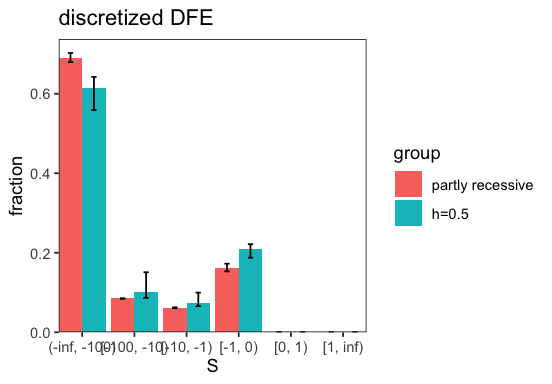

In [14]:
p <- fd$DFE$plot_many(c(inf$get_dfe(), inf2$get_dfe()), labels=c('partly recessive', 'h=0.5'))

We see that assuming mutations are partly recessive leads to a more deleterious inferred DFE since stronger selection is necessary to remove a similar amount of recessive mutations.

We can also let `h` vary when inferring the DFE (cf. the {doc}`simulation guide <../R/simulation>`).

## Folded inference
To infer the DFE from a folded SFS, simply pass folded spectra to {class}`~fastdfe.base_inference.BaseInference`. Folded inference is performed whenever the spectra are folded, i.e., when all entries where the derived allele is the major allele are zero. Folded spectra contain little information on beneficial mutations so we only infer the deleterious part of the DFE here.

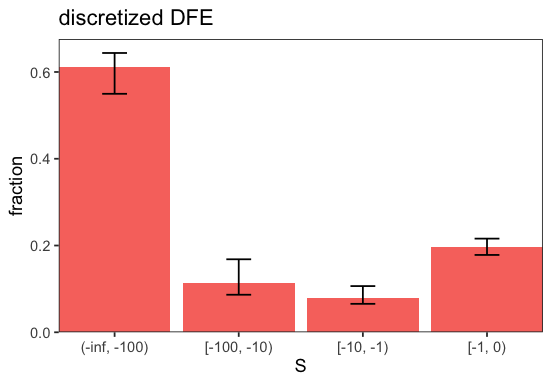

In [15]:
# create inference object
inf <- fd$BaseInference(
    sfs_neut = sfs_neut$fold(),
    sfs_sel = sfs_sel$fold()
)

# run inference
sfs_modelled <- inf$run()

p <- inf$plot_discretized(intervals = c(-Inf, -100, -10, -1, 0));

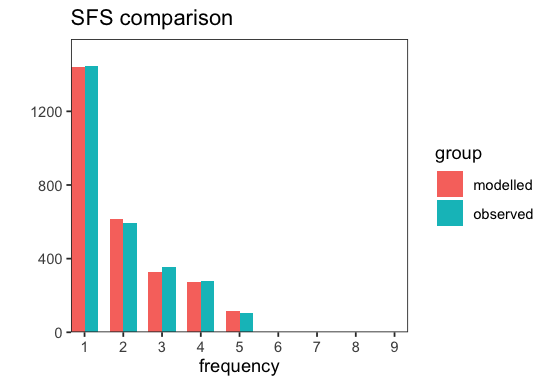

In [16]:
p <- inf$plot_sfs_comparison();

## Serialization
Inference objects can be serialized to JSON files for later use (cf. {func}`~fastdfe.base_inference.BaseInference.to_file`).

In [17]:
# save the inference object to a file
# unserialize with BaseInference$from_file
inf$to_file("serialized.json")

# we can also save a short summary to fa ile
inf$get_summary()$to_file("summary.json")

## Joint inference
fastDFE supports joint inference of several SFS types, where any parameters can be shared between types. In this example, we create a {class}`~fastdfe.joint_inference.JointInference` object with two types, where we share ``eps``, the rate of ancestral misidentification and ``S_d``, the mean selection coefficient for deleterious mutations (cf. {class}`~fastdfe.parametrization.GammaExpParametrization`). For more complex stratifications, see the {class}`~fastdfe.parser.Parser`) module.

In [18]:
# neutral SFS for two types
sfs_neut <- fd$Spectra(list(
    pendula = c(177130, 997, 441, 228, 156, 117, 114, 83, 105, 109, 0),
    pubescens = c(172528, 3612, 1359, 790, 584, 427, 325, 234, 166, 76, 0)
))

# selected SFS for two types
sfs_sel <- fd$Spectra(list(
    pendula = c(797939, 1329, 499, 265, 162, 104, 117, 90, 94, 119, 0),
    pubescens = c(791106, 5326, 1741, 1005, 756, 546, 416, 294, 177, 104, 0)
))

# create inference object
inf <- fd$JointInference(
    sfs_neut = sfs_neut,
    sfs_sel = sfs_sel,
    shared_params = list(fd$SharedParams(types = c("pendula", "pubescens"), params = list("S_d")))
)

# run inference
sfs_modelled <- inf$run()

{class}`~fastdfe.joint_inference.JointInference` both runs the joint inference and marginal inference where each type is inferred separately. To see this better we can plot the inferred parameters for the different inference types.

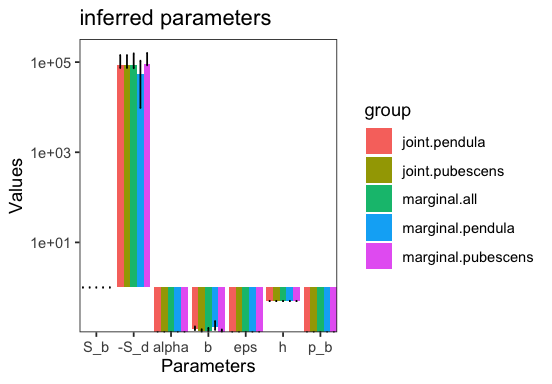

In [19]:
p <- inf$plot_inferred_parameters();

``marginal.pendula`` and ``marginal.pubescens`` are the marginal inferences for the respective type. ``marginal.all`` is the marginal inference obtaining by adding up the spectra of all types. ``joint.pendula`` and ``join.pubescens`` are the joint inferences for the respective type. We can see that ``eps`` and ``S_d`` are indeed shared between the two. The parameter ``alpha`` in the plot denotes the proportion of beneficial non-synonymous substitutions. Each marginal inference is a {class}`~fastdfe.base_inference.BaseInference` object itself and can be accessed via ``inf.marginal_inferences[type]``.

We can now also investigate to what extent the inferred DFEs differ:

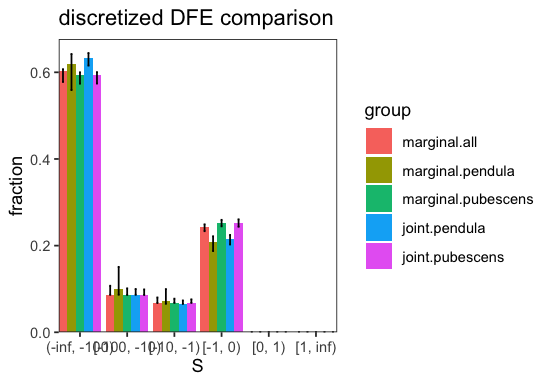

In [20]:
p <- inf$plot_discretized();

### Model comparison
We can obtain information about the goodness of fit achieved by sharing the parameter by performing a likelihood ratio test (cf. {func}`~fastdfe.joint_inference.JointInference.perform_lrt_shared`). This compares the likelihood of the joint inference with the product of the marginal likelihoods.

In [21]:
inf$perform_lrt_shared()

[1] 0.5097493

The test is not significant, indicating that the simpler model of sharing the parameters explains the data sufficiently well. Indeed, we do not observe a lot of differences between the inferred parameters of joint and the marginal inferences.

## Covariates
{class}`~fastdfe.joint_inference.JointInference` also supports the inclusion of covariates associates with the different SFS types. This provides more powerful model testing and reduces the number of parameters that need to be estimated for the joint inference. For a more interesting example we stratify the SFS of `B. pendula` by the sites' reference base as is described in more detail in the {mod}`~fastdfe.parser` module.

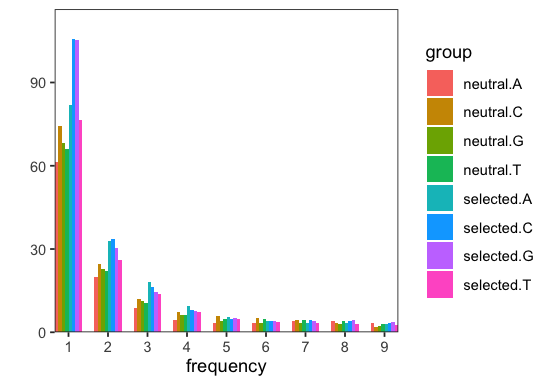

In [22]:
# instantiate parser
p <- fd$Parser(
    n = 10,
    vcf = paste0(
        "https://github.com/Sendrowski/fastDFE/",
        "blob/dev/resources/genome/betula/",
        "all.polarized.deg.subset.200000.vcf.gz?raw=true"
    ),
    stratifications = list(fd$DegeneracyStratification(), fd$AncestralBaseStratification())
)

# parse SFS
s <- p$parse()

# visualize spectra
p <- s$plot();

We now create the inference object from the spectra. In this contrived example we make up some covariates that covary with ``S_d``, the mean strength of negative selection. Covariates introduce a linear relationship by default but this can be modified by specifying a custom callback function (see {class}`~fastdfe.optimization.Covariate`).

In [23]:
# create inference object
inf <- fd$JointInference(
    sfs_neut = s$select('neutral.*')$merge_groups(1),
    sfs_sel = s$select('selected.*')$merge_groups(1),
    covariates = list(fd$Covariate(param = 'S_d', values = list(A = 1, C = 2, T = 3, G = 4))),
    n_runs = 50  # increase number of initial runs for stability
)

# run inference
sfs_modelled <- inf$run()

Let's visualize the inferred parameters

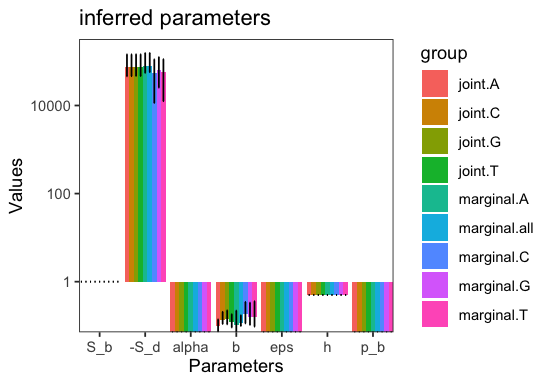

In [24]:
p <- inf$plot_inferred_parameters();

We observe that ``S_d`` shows little variation across the jointly inferred types, because it does not change linearly with respect to the arbitrary covariates specified. Indeed, the median of the covariate across all bootstrap replicates is close to zero. Note that covariates are named ``c0``, ``c1``, etc., by default.

In [25]:
median(inf$bootstraps[['A.c0']])

[1] 0

### Model comparison
We can perform a likelihood ratio test to see whether including the covariates produces a significantly better fit than simply sharing the parameter in question among the types (cf. {func}`~fastdfe.joint_inference.JointInference.perform_lrt_covariates`).

In [26]:
inf$perform_lrt_covariates()

[1] 1

As expected, the specified covariates do not improve the fit significantly.